We will here go through an example of using a reserch-grade de-noising model. The model is TomoGAN (Liu, Z., Bicer, T., Kettimuthu, R., Gursoy, D., De Carlo, F. and Foster, I., 2020. TomoGAN: low-dose synchrotron x-ray tomography with generative adversarial networks: discussion. JOSA A, vol. 37(3), pp.422-434, and arXiv:1902.07582). Because training this model takes several hours on GPU clusters, we will not here train it but instead use a pre-trained model on realistic data sets.

We start - as usual - by importing various python libraries.

In [1]:
import tensorflow as tf 
import numpy as np 
from matplotlib import pyplot as plt
import sys, time, imageio, h5py, skimage, glob, os, shutil

2023-10-06 19:16:29.201963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# overwrite anyway 
if os.path.isdir('dataset'): 
    shutil.rmtree('dataset')
os.mkdir('dataset') # to save temp output

!wget -O dataset/demo-dataset-real4test.h5 https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/dataset/demo-dataset-real4test.h5

--2023-10-06 19:16:37--  https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/dataset/demo-dataset-real4test.h5
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 33556480 (32M) [application/octet-stream]
Sauvegarde en : « dataset/demo-dataset-real4test.h5 »

dataset/demo-datase 100%[===================>]  32,00M  4,80MB/s    ds 9,6s    

2023-10-06 19:16:48 (3,34 MB/s) — « dataset/demo-dataset-real4test.h5 » sauvegardé [33556480/33556480]



We will then load noisy images.  

In [3]:
with h5py.File('dataset/demo-dataset-real4test.h5', 'r') as h5fd:
    ns_img_test_real = h5fd["test_ns"][:]
    gt_img_test_real = h5fd["test_gt"][:]

Next, we load the pre-trained model and print out a summary of the model characteristics.

In [4]:
# overwrite anyway 
if os.path.isdir('model'): 
    shutil.rmtree('model')
os.mkdir('model') # to save temp output

!wget -O model/TomoGAN.h5 https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/model/TomoGAN.h5

--2023-10-06 19:17:11--  https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/model/TomoGAN.h5
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2854872 (2,7M) [application/octet-stream]
Sauvegarde en : « model/TomoGAN.h5 »

model/TomoGAN.h5    100%[===================>]   2,72M  2,77MB/s    ds 1,0s    

2023-10-06 19:17:13 (2,77 MB/s) — « model/TomoGAN.h5 » sauvegardé [2854872/2854872]



In [5]:
TomoGAN_mdl = tf.keras.models.load_model('model/TomoGAN.h5', )
TomoGAN_mdl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 8)        16        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       2336      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_1[0][0]']            
                                                                                              

We then apply TomoGAN to the noisy images and output the results.

1/1 [==============================] - 2s 2s/step


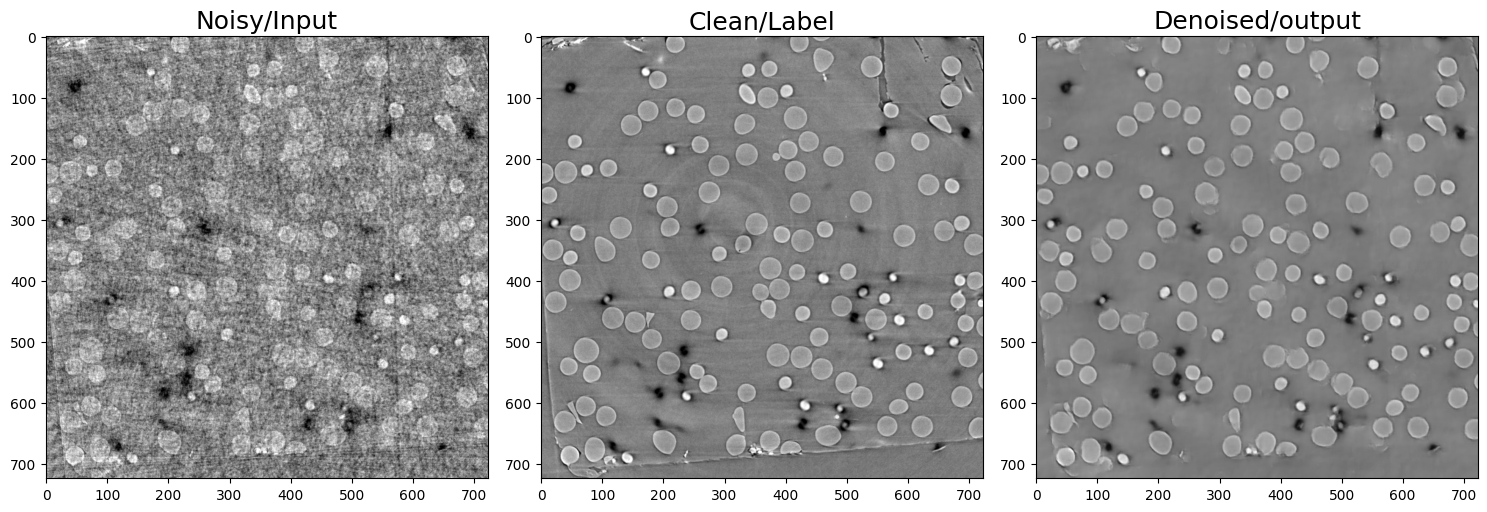

1/1 [==============================] - 2s 2s/step


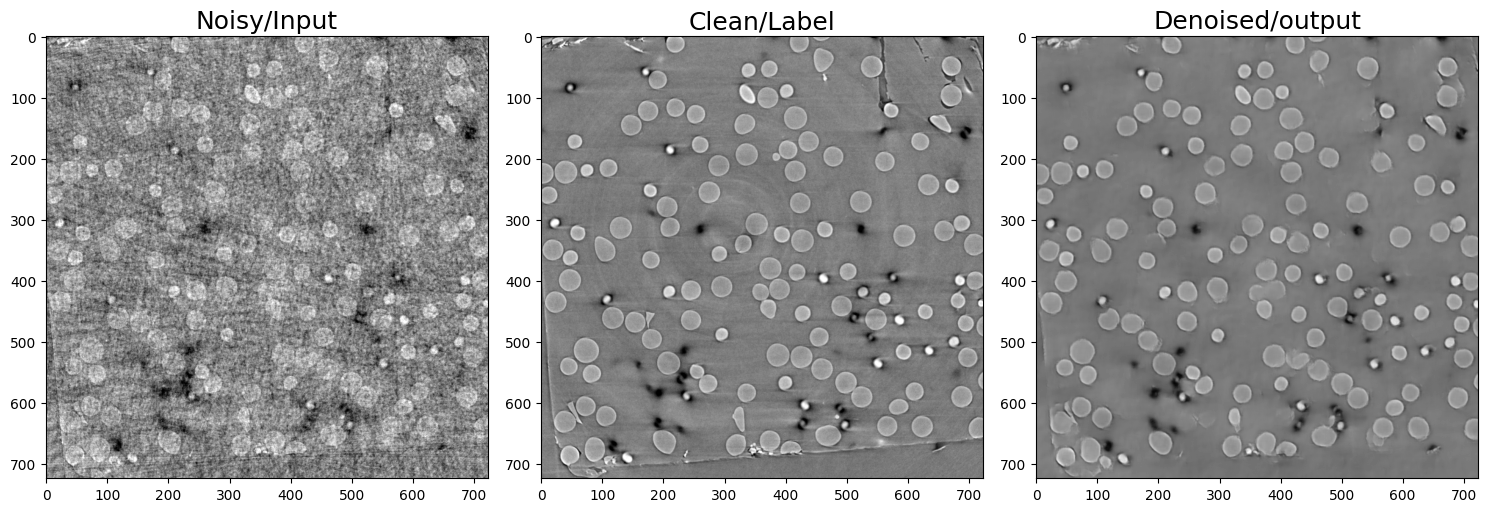

In [6]:
for _idx in range(ns_img_test_real.shape[0])[:2]:
    # just one line of code to denoise, need to remember that the input is four dimension [n, h, w, c] 
    dn_img = TomoGAN_mdl.predict(ns_img_test_real[_idx:_idx+1,:,:,np.newaxis]).squeeze()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ns_img_test_real[_idx, 200:-100, 200:-100], cmap='gray')
    plt.title('Noisy/Input', fontsize=18)
    plt.subplot(132)
    plt.imshow(gt_img_test_real[_idx, 200:-100, 200:-100], cmap='gray')
    plt.title('Clean/Label', fontsize=18)
    plt.subplot(133)
    plt.imshow(dn_img[200:-100, 200:-100], cmap='gray')
    plt.title('Denoised/output', fontsize=18)
    plt.tight_layout(); plt.show(); plt.close()

The de-noising can be done in batches to accelerate the process.

In [7]:
batch_sz = 4
_idx = 0
tick = time.time()
dn_img = TomoGAN_mdl.predict(ns_img_test_real[_idx:_idx+batch_sz,:,:,np.newaxis]).squeeze()
print('It takes %.1f seconds to denoise %d, %dx%d images,' % (time.time() - tick, batch_sz, \
                                                            ns_img_test_real.shape[1],\
                                                            ns_img_test_real.shape[2]))
dn_img.shape

1/1 [==============================] - 7s 7s/step
It takes 7.5 seconds to denoise 4, 1024x1024 images,


(4, 1024, 1024)

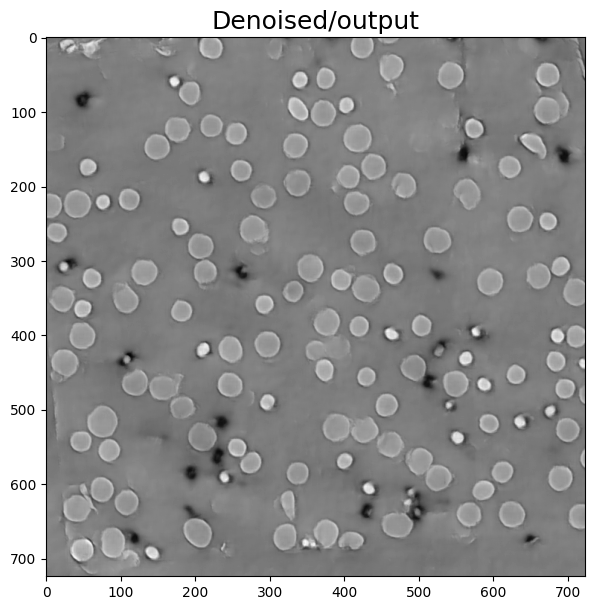

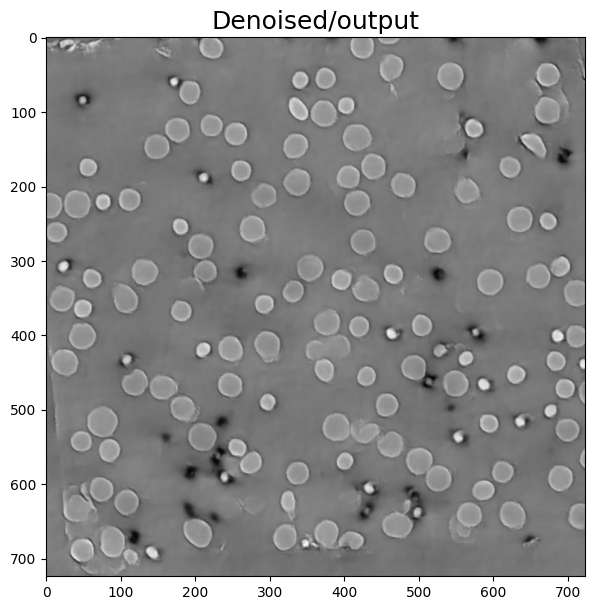

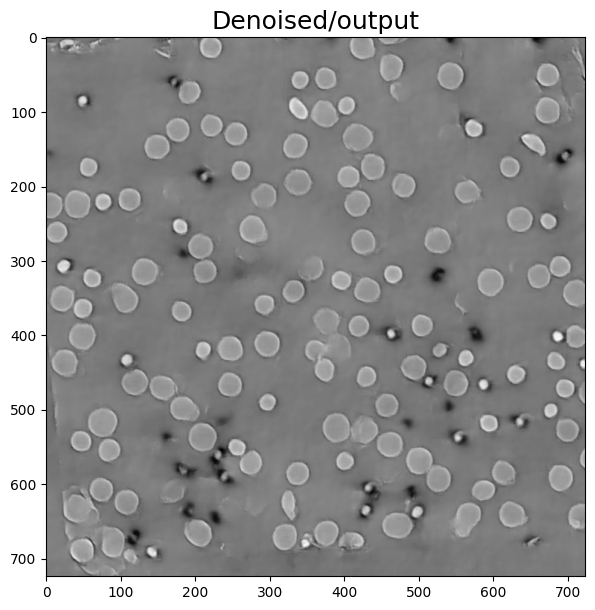

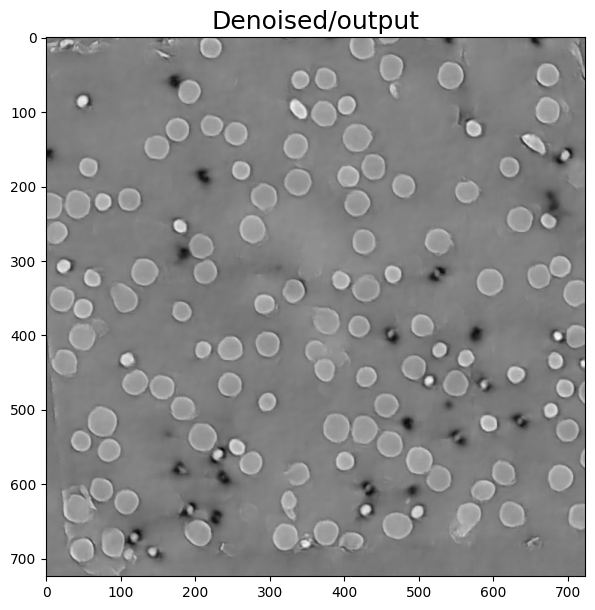

In [8]:
for _img_dn in dn_img:
    plt.figure(figsize=(7, 7))
    plt.imshow(_img_dn[200:-100, 200:-100], cmap='gray')
    plt.title('Denoised/output', fontsize=18)
    plt.show(); plt.close()